# Lane Detection for Autonomous Vehicles

## Computer Vision Project

---

**Supervised by:** Pr. Abdelghani Ghazdali    
**Made by:** Omar AFIDI and Chaimae ELBAHCHOUMI  
**Academic Year:** 2025-2026

---

This notebook presents our lane detection pipeline built **from scratch**, using classical algorithmic approaches in computer vision.

## Table of Contents

1. [Introduction and Context](#1-introduction-and-context)
2. [Import Libraries](#2-import-libraries)
3. [Detection Pipeline](#3-detection-pipeline)
   - Step 1: Grayscale Conversion
   - Step 2: Gaussian Blur
   - Step 3: Edge Detection (Canny)
   - Step 4: Region of Interest (ROI)
   - Step 5: Hough Transform
   - Step 6: Line Filtering and Adjustment
   - Step 7: Drawing Lines
4. [Final Result](#4-final-result)
5. [Conclusion](#5-conclusion)

---

## 1. Introduction and Context

### Project Objective

Create a system capable of detecting lane markings on a road in real-time, applicable to autonomous vehicles and line-following robots.

### Problem Statement

Autonomous vehicles require reliable lane detection to avoid accidents and maintain safe driving. Poor detection can lead to major risks on the road.

### Chosen Approach

As this is our **first computer vision project**, we chose a **"from scratch"** approach to:
- Understand the fundamentals of Computer Vision algorithms
- Avoid complex approaches (Deep Learning, CNN)
- Master basic concepts before using advanced techniques

**Technologies used:** Python, NumPy, OpenCV (only for display)

---

## 2. Import Libraries

In [280]:
import numpy as np
import cv2
import math
import matplotlib.pyplot as plt

# Configuration for image display
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

print("Libraries imported successfully!")

Libraries imported successfully!


---

## 3. Detection Pipeline

### Pipeline Overview
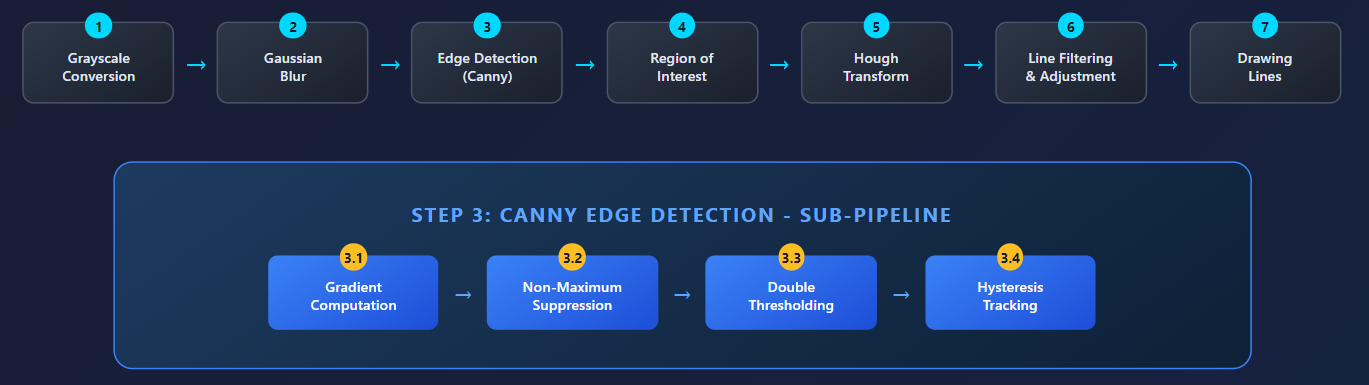
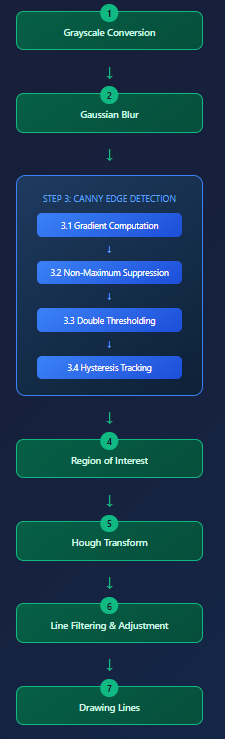
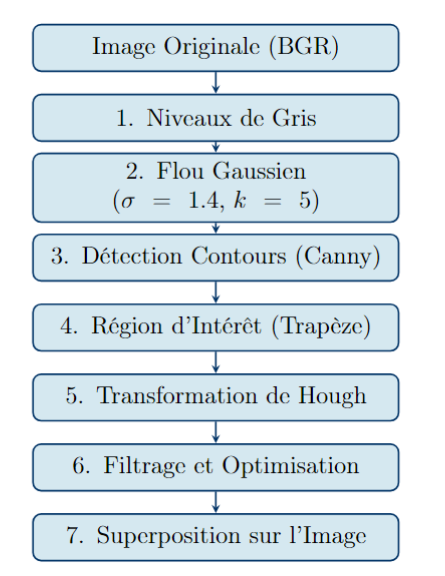

### Loading the Original Image

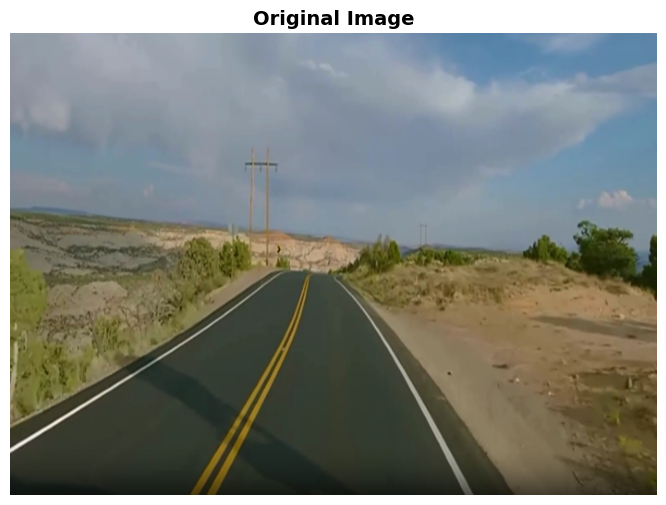

Image dimensions: (500, 700, 3)


In [281]:
# Load image
image_path = "dataset/frame.png"
original_image = cv2.imread(image_path)
original_image = cv2.resize(original_image, (700, 500))

# Convert BGR -> RGB for matplotlib display
image_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

# Display
plt.figure(figsize=(10, 6))
plt.imshow(image_rgb)
plt.title("Original Image", fontsize=14, fontweight='bold')
plt.axis('off')
plt.show()

print(f"Image dimensions: {original_image.shape}")

---

## Step 1: Grayscale Conversion

### Purpose
Reduce image complexity from **3 channels (RGB)** to **1 single channel** to simplify subsequent calculations.

### Mathematical Method
We use the **arithmetic mean** of the three channels:

$$Gray(x,y) = \frac{R(x,y) + G(x,y) + B(x,y)}{3}$$

### Why this step?
- Reduces the amount of data to process
- Prepares the image for edge detection
- Color information is not necessary for detecting edges

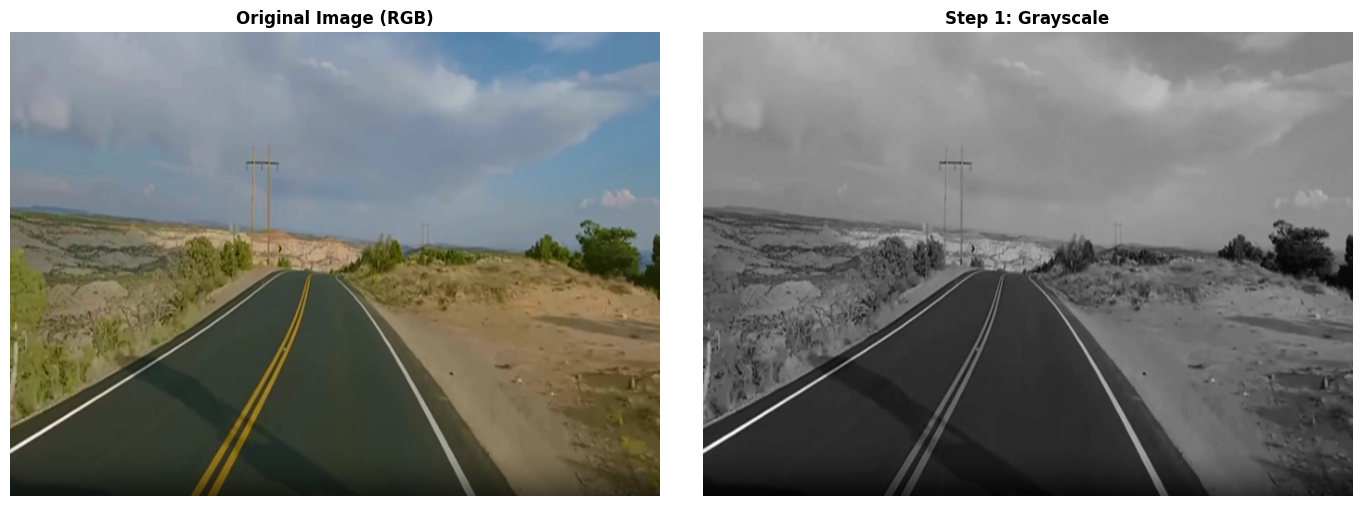

Dimensions after conversion: (500, 700)
Value range: [13, 244]


In [282]:
def gray_scale(image: np.ndarray) -> np.ndarray:
    """
    Converts an RGB image to grayscale.
    
    Parameters:
        image: RGB image of shape (H, W, 3)
    
    Returns:
        Grayscale image of shape (H, W)
    """
    # Use uint16 to avoid overflow during addition
    result = np.zeros_like(image[:, :, 0], dtype=np.uint16)
    
    # Sum of three channels
    for i in range(3):
        result += image[:, :, i]
    
    # Divide by 3 and convert to uint8
    return (result // 3).astype(np.uint8)

# Apply
gray_image = gray_scale(original_image)

# Comparative display
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].imshow(image_rgb)
axes[0].set_title("Original Image (RGB)", fontsize=12, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(gray_image, cmap='gray')
axes[1].set_title("Step 1: Grayscale", fontsize=12, fontweight='bold')
axes[1].axis('off')

plt.tight_layout()
plt.show()

print(f"Dimensions after conversion: {gray_image.shape}")
print(f"Value range: [{gray_image.min()}, {gray_image.max()}]")

---

## Step 2: Gaussian Blur

### Purpose
Reduce **noise** in the image and smooth irrelevant details to avoid false positives during edge detection.

### Mathematical Method
We apply a **convolution** with a **Gaussian kernel**.

#### 2D Gaussian Kernel Formula:

$$G(x, y) = \frac{1}{2\pi\sigma^2} e^{-\frac{x^2 + y^2}{2\sigma^2}}$$

Where:
- $\sigma$ is the standard deviation (controls blur intensity)
- $(x, y)$ are coordinates relative to the kernel center

#### Convolution Operation:

$$I'(x,y) = \sum_{i=-k}^{k} \sum_{j=-k}^{k} G(i,j) \cdot I(x+i, y+j)$$

### Why this step?
- Attenuates high-frequency noise
- Avoids spurious edge detections
- Smooths unwanted textures

Gaussian Kernel 5x5 (σ=1.4):
[[0.0121 0.0261 0.0337 0.0261 0.0121]
 [0.0261 0.0561 0.0724 0.0561 0.0261]
 [0.0337 0.0724 0.0935 0.0724 0.0337]
 [0.0261 0.0561 0.0724 0.0561 0.0261]
 [0.0121 0.0261 0.0337 0.0261 0.0121]]

Kernel sum: 1.0000


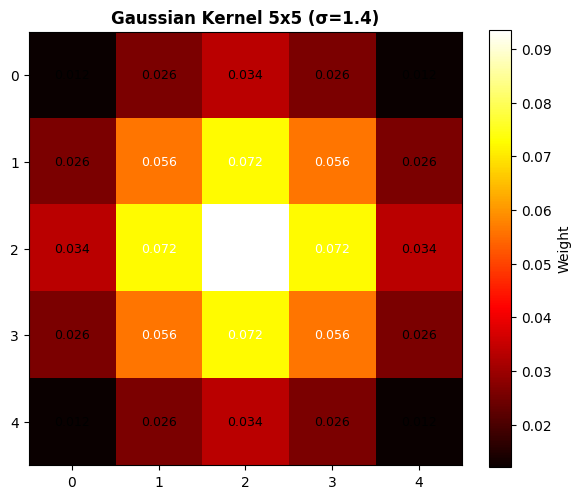

In [283]:
def create_gaussian_kernel(k: int, sigma: float) -> np.ndarray:
    """
    Creates a 2D Gaussian kernel.
    
    Parameters:
        k: Kernel size (must be odd)
        sigma: Standard deviation of the Gaussian distribution
    
    Returns:
        Normalized Gaussian kernel of shape (k, k)
    """
    mid = k // 2
    kernel = np.zeros((k, k), dtype=np.float32)

    for i in range(k):
        for j in range(k):
            x = i - mid
            y = j - mid
            # Apply Gaussian formula
            kernel[i][j] = math.exp(-(x*x + y*y) / (2 * sigma * sigma)) / (2 * math.pi * sigma * sigma)

    # Normalize so sum = 1
    return kernel / kernel.sum()

# Kernel visualization
kernel = create_gaussian_kernel(k=5, sigma=1.4)
print("Gaussian Kernel 5x5 (σ=1.4):")
print(np.round(kernel, 4))
print(f"\nKernel sum: {kernel.sum():.4f}")

# Heatmap visualization
fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(kernel, cmap='hot', interpolation='nearest')
ax.set_title("Gaussian Kernel 5x5 (σ=1.4)", fontsize=12, fontweight='bold')
plt.colorbar(im, ax=ax, label='Weight')

# Add value annotations on each cell
for i in range(kernel.shape[0]):
    for j in range(kernel.shape[1]):
        text = ax.text(j, i, f'{kernel[i, j]:.3f}', ha='center', va='center', 
                       color='white' if kernel[i, j] > kernel.max()/2 else 'black', fontsize=9)

ax.set_xticks(range(5))
ax.set_yticks(range(5))
plt.tight_layout()
plt.show()

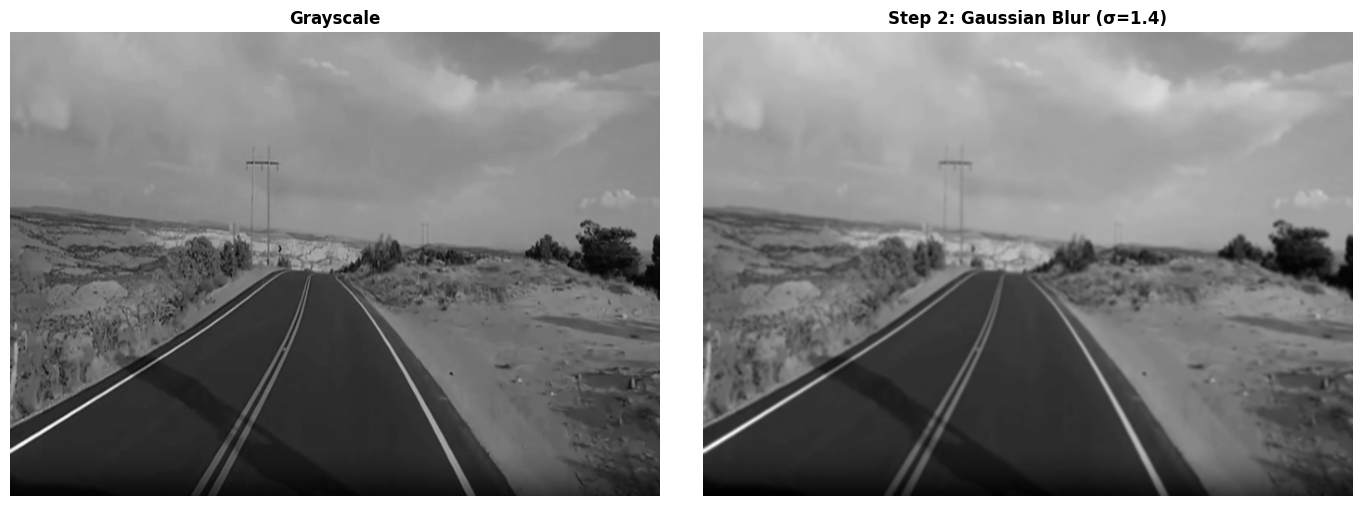

In [284]:
def gaussian_blur(image: np.ndarray, kernel: np.ndarray) -> np.ndarray:
    """
    Applies Gaussian blur via convolution.
    
    Parameters:
        image: Grayscale image
        kernel: Gaussian kernel
    
    Returns:
        Blurred image
    """
    k = len(kernel)
    H, W = image.shape
    blurred_img = np.zeros((H, W), dtype=np.float32)
    
    # Padding to handle borders
    padded_img = np.pad(image, pad_width=(k // 2), mode="edge")

    # Convolution
    for i in range(k):
        for j in range(k):
            blurred_img += kernel[i][j] * padded_img[i:i+H, j:j+W]
    
    return blurred_img.astype(np.uint8)

# Apply
blurred_image = gaussian_blur(gray_image, kernel)

# Comparative display
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].imshow(gray_image, cmap='gray')
axes[0].set_title("Grayscale", fontsize=12, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(blurred_image, cmap='gray')
axes[1].set_title("Step 2: Gaussian Blur (σ=1.4)", fontsize=12, fontweight='bold')
axes[1].axis('off')

plt.tight_layout()
plt.show()

---

## Step 3: Edge Detection

This step is **crucial** and uses the **Canny Edge Detection** algorithm. It is divided into several sub-steps.

### 3.1 Gradient Calculation (Sobel Operator)

#### Purpose
Detect intensity changes (edges) in the image.

#### Method
We use **Sobel operators** to calculate partial derivatives:

**Horizontal Sobel Kernel ($G_x$):**
$$G_x = \begin{bmatrix} -1 & 0 & 1 \\ -2 & 0 & 2 \\ -1 & 0 & 1 \end{bmatrix}$$

**Vertical Sobel Kernel ($G_y$):**
$$G_y = \begin{bmatrix} 1 & 2 & 1 \\ 0 & 0 & 0 \\ -1 & -2 & -1 \end{bmatrix}$$

**Gradient Magnitude:**
$$G = |G_x| + |G_y|$$

**Gradient Direction:**
$$\theta = \arctan\left(\frac{G_y}{G_x}\right)$$

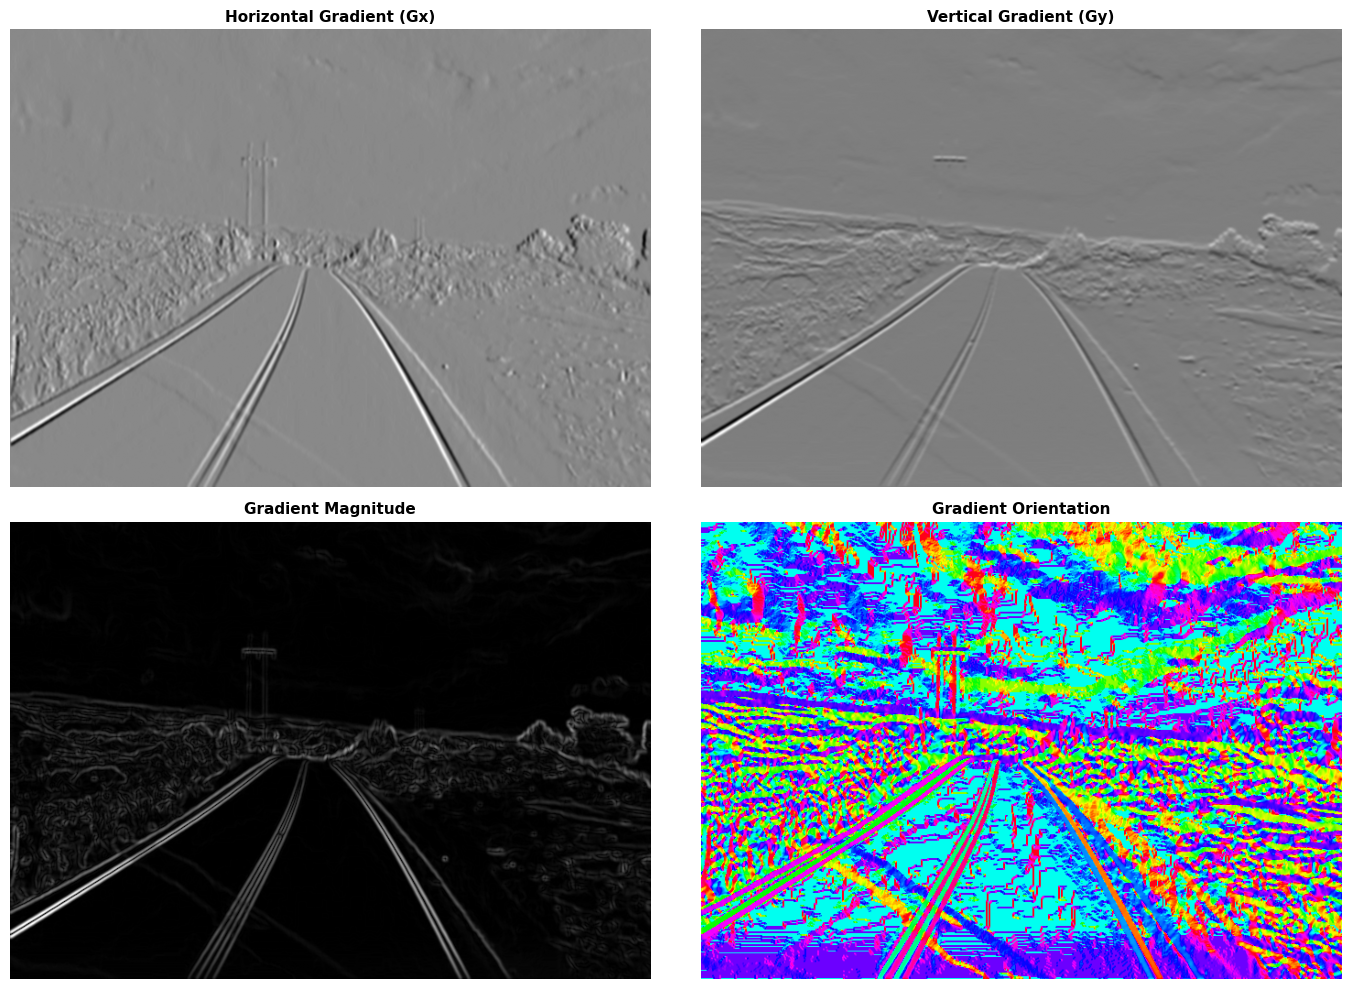

In [285]:
def first_derivative_x(image: np.ndarray) -> np.ndarray:
    """
    Computes horizontal derivative using Sobel operator.
    """
    kernel = np.array([[-1, 0, 1],
                       [-2, 0, 2],
                       [-1, 0, 1]], dtype=np.float32)
    
    H, W = image.shape
    padded = np.pad(image, 1, mode="edge")
    dx = np.zeros((H, W), dtype=np.float32)
    
    for i in range(3):
        for j in range(3):
            dx += kernel[i, j] * padded[i:i+H, j:j+W]
    
    return dx

def first_derivative_y(image: np.ndarray) -> np.ndarray:
    """
    Computes vertical derivative using Sobel operator.
    """
    kernel = np.array([[1, 2, 1],
                       [0, 0, 0],
                       [-1, -2, -1]], dtype=np.float32)
    
    H, W = image.shape
    padded = np.pad(image, 1, mode="edge")
    dy = np.zeros((H, W), dtype=np.float32)
    
    for i in range(3):
        for j in range(3):
            dy += kernel[i, j] * padded[i:i+H, j:j+W]
    
    return dy

def gradient_magnitude(dx: np.ndarray, dy: np.ndarray) -> np.ndarray:
    """Computes gradient magnitude."""
    return np.abs(dx) + np.abs(dy)

def gradient_orientation(dx: np.ndarray, dy: np.ndarray) -> np.ndarray:
    """Computes gradient orientation."""
    return np.arctan2(dy, dx)

# Calculate gradients
dx = first_derivative_x(blurred_image)
dy = first_derivative_y(blurred_image)
magnitude = gradient_magnitude(dx, dy)
orientation = gradient_orientation(dx, dy)

# Display
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].imshow(dx, cmap='gray')
axes[0, 0].set_title("Horizontal Gradient (Gx)", fontsize=11, fontweight='bold')
axes[0, 0].axis('off')

axes[0, 1].imshow(dy, cmap='gray')
axes[0, 1].set_title("Vertical Gradient (Gy)", fontsize=11, fontweight='bold')
axes[0, 1].axis('off')

axes[1, 0].imshow(magnitude, cmap='gray')
axes[1, 0].set_title("Gradient Magnitude", fontsize=11, fontweight='bold')
axes[1, 0].axis('off')

axes[1, 1].imshow(orientation, cmap='hsv')
axes[1, 1].set_title("Gradient Orientation", fontsize=11, fontweight='bold')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

### 3.2 Non-Maximum Suppression

#### Purpose
Refine edges by keeping only pixels that are **local maxima** in the gradient direction.

#### Method
For each pixel:
1. Determine the gradient direction (0°, 45°, 90°, 135°)
2. Compare with the two neighbors in that direction
3. Keep only if it's the local maximum

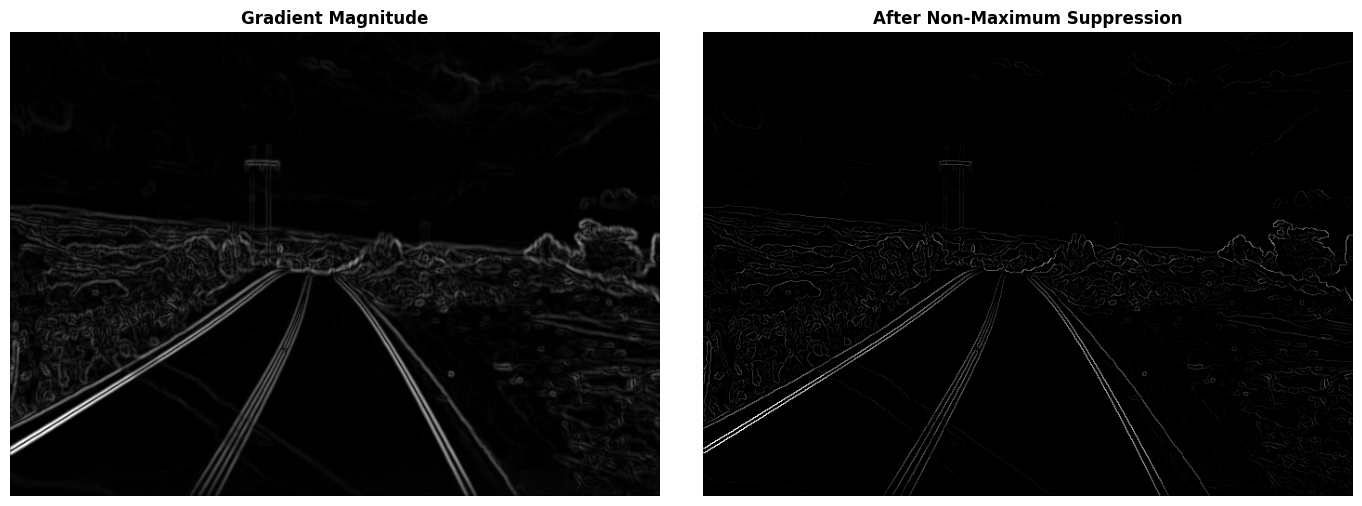

In [286]:
def non_max_suppression(mag: np.ndarray, ang: np.ndarray) -> np.ndarray:
    """
    Non-maximum suppression to refine edges.
    
    Parameters:
        mag: Gradient magnitude
        ang: Gradient orientation (in radians)
    
    Returns:
        Image with refined edges
    """
    H, W = mag.shape
    Z = np.zeros((H, W), dtype=np.float32)
    
    # Convert to degrees
    angle = ang * 180.0 / np.pi
    angle[angle < 0] += 180

    # Padding to access neighbors
    M = np.pad(mag, 1, mode="constant", constant_values=0)
    center = M[1:-1, 1:-1]
    left = M[1:-1, :-2]
    right = M[1:-1, 2:]
    up = M[:-2, 1:-1]
    down = M[2:, 1:-1]
    upleft = M[:-2, :-2]
    upright = M[:-2, 2:]
    downleft = M[2:, :-2]
    downright = M[2:, 2:]

    # Comparison based on direction
    Z0 = (center > left) & (center >= right)        # 0°
    Z90 = (center > up) & (center >= down)          # 90°
    Z45 = (center > downleft) & (center >= upright) # 45°
    Z135 = (center > upleft) & (center >= downright) # 135°

    mask0 = ((angle < 22.5) | (angle >= 157.5)) & Z0
    mask45 = ((angle >= 22.5) & (angle < 67.5)) & Z45
    mask90 = ((angle >= 67.5) & (angle < 112.5)) & Z90
    mask135 = ((angle >= 112.5) & (angle < 157.5)) & Z135

    mask = mask0 | mask45 | mask90 | mask135
    Z[mask] = center[mask]
    
    return Z

# Apply
nms_image = non_max_suppression(magnitude, orientation)

# Display
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].imshow(magnitude, cmap='gray')
axes[0].set_title("Gradient Magnitude", fontsize=12, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(nms_image, cmap='gray')
axes[1].set_title("After Non-Maximum Suppression", fontsize=12, fontweight='bold')
axes[1].axis('off')

plt.tight_layout()
plt.show()

### 3.3 Double Thresholding (Hysteresis Thresholding)

#### Purpose
Classify pixels as **strong**, **weak**, or **suppressed** based on their intensity.

#### Method
- **High threshold**: If pixel ≥ high_threshold → strong pixel (255)
- **Low threshold**: If low_threshold ≤ pixel < high_threshold → weak pixel (25)
- Otherwise → suppressed pixel (0)

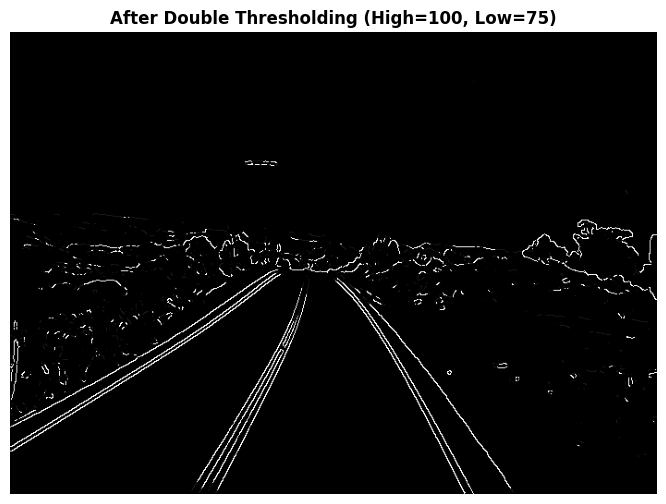

Strong pixels (255): 6307
Weak pixels (25): 2807


In [287]:
def threshold(nms: np.ndarray, high_th: int, low_th: int) -> np.ndarray:
    """
    Applies double thresholding.
    
    Parameters:
        nms: Image after non-maximum suppression
        high_th: High threshold
        low_th: Low threshold
    
    Returns:
        Thresholded image (255=strong, 25=weak, 0=suppressed)
    """
    thresholded = np.zeros(nms.shape, dtype=np.uint8)
    
    strong_mask = nms >= high_th
    weak_mask = (nms >= low_th) & (nms < high_th)
    
    thresholded[weak_mask] = 25    # Weak pixels
    thresholded[strong_mask] = 255  # Strong pixels
    
    return thresholded

# Thresholding parameters
HIGH_THRESHOLD = 100
LOW_THRESHOLD = 75

thresholded_image = threshold(nms_image, HIGH_THRESHOLD, LOW_THRESHOLD)

# Display
plt.figure(figsize=(10, 6))
plt.imshow(thresholded_image, cmap='gray')
plt.title(f"After Double Thresholding (High={HIGH_THRESHOLD}, Low={LOW_THRESHOLD})", fontsize=12, fontweight='bold')
plt.axis('off')
plt.show()

print(f"Strong pixels (255): {np.sum(thresholded_image == 255)}")
print(f"Weak pixels (25): {np.sum(thresholded_image == 25)}")

### 3.4 Hysteresis Edge Tracking

#### Purpose
Connect weak pixels to strong pixels to form continuous edges.

#### Method
A weak pixel becomes strong if it has at least one strong neighbor (8-connectivity).

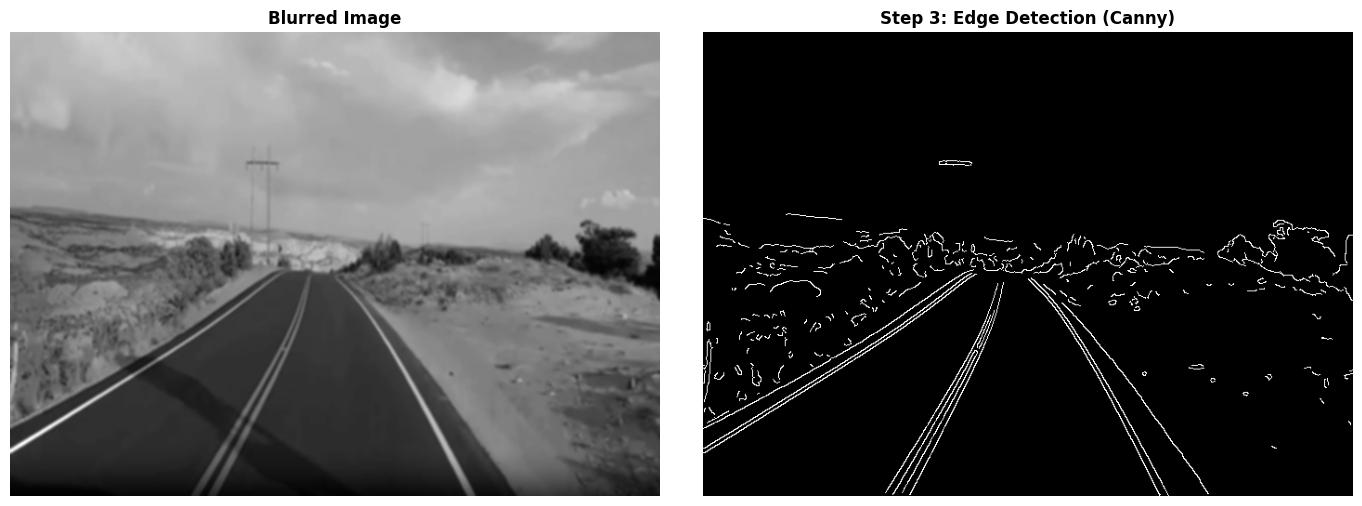

Edge detection completed!


In [288]:
def hysteresis_tracking(img: np.ndarray) -> np.ndarray:
    """
    Hysteresis edge tracking.
    Weak pixels connected to strong pixels become strong.
    """
    img = img.copy().astype(np.uint8)
    M, N = img.shape

    while True:
        # Padding to access 8 neighbors
        padded = np.pad(img, pad_width=1, mode='constant', constant_values=0)
        
        # The 8 neighbors
        neighbors = np.stack([
            padded[:-2, :-2], padded[:-2, 1:-1], padded[:-2, 2:],
            padded[1:-1, :-2],                   padded[1:-1, 2:],
            padded[2:, :-2],  padded[2:, 1:-1],  padded[2:, 2:]
        ], axis=0)
        
        # Check if any neighbor is strong
        any_strong_neighbor = np.any(neighbors == 255, axis=0)
        
        # Weak pixels to promote
        weak_mask = (img == 25)
        to_promote = weak_mask & any_strong_neighbor
        
        if not np.any(to_promote):
            break
        
        img[to_promote] = 255

    # Remove remaining weak pixels
    img[img == 25] = 0
    
    return img

# Apply
edges = hysteresis_tracking(thresholded_image)

# Final edge display
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].imshow(blurred_image, cmap='gray')
axes[0].set_title("Blurred Image", fontsize=12, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(edges, cmap='gray')
axes[1].set_title("Step 3: Edge Detection (Canny)", fontsize=12, fontweight='bold')
axes[1].axis('off')

plt.tight_layout()
plt.show()

print("Edge detection completed!")

---

## Step 4: Region of Interest (ROI)

### Purpose
Isolate only the **road area** where lane lines appear.

### Method
Create a **polygonal mask** (trapezoid) that corresponds to the road's perspective.

### Why this step?
- Eliminate irrelevant elements (sky, trees, buildings, other vehicles)
- Reduce false positives
- Focus processing on the useful area

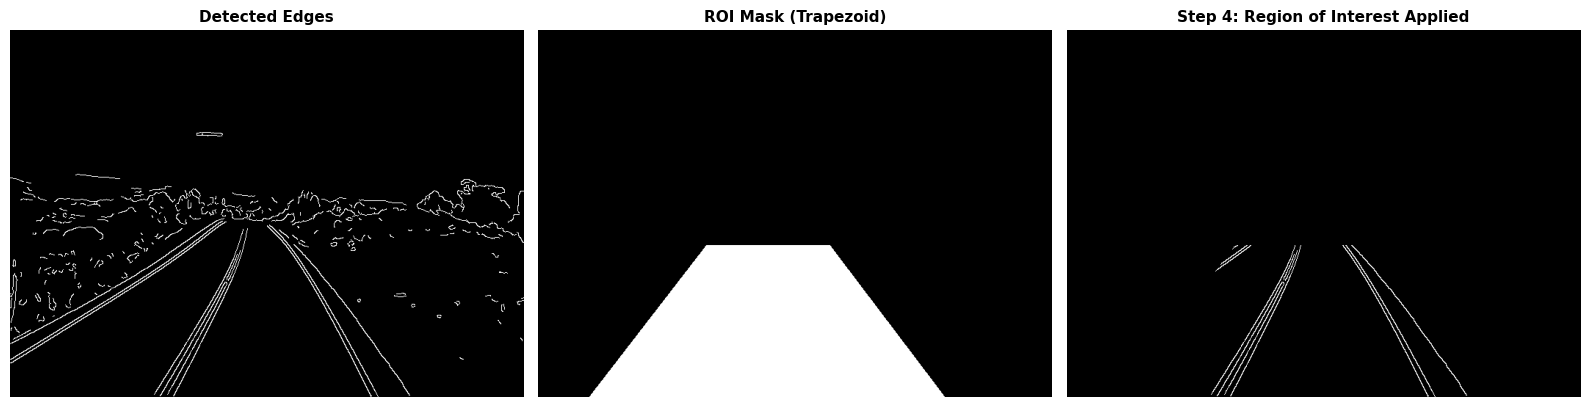

In [289]:
def region_of_interest(image: np.ndarray) -> tuple:
    """
    Applies a trapezoidal mask to isolate the region of interest.
    
    Parameters:
        image: Grayscale image
    
    Returns:
        (masked_image, mask)
    """
    mask = np.zeros_like(image)
    rows, cols = image.shape
    new_img = image.copy()

    # Trapezoid definition (adjusted for road perspective)
    bottom_left = [cols * 0.1, rows]
    top_left = [229, 293]
    bottom_right = [cols * 0.79, rows]
    top_right = [397, 293]

    points = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    cv2.fillPoly(mask, points, 100)
    
    return mask * new_img, mask

# Apply
roi_image, roi_mask = region_of_interest(edges)

# Display
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

axes[0].imshow(edges, cmap='gray')
axes[0].set_title("Detected Edges", fontsize=11, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(roi_mask, cmap='gray')
axes[1].set_title("ROI Mask (Trapezoid)", fontsize=11, fontweight='bold')
axes[1].axis('off')

axes[2].imshow(roi_image, cmap='gray')
axes[2].set_title("Step 4: Region of Interest Applied", fontsize=11, fontweight='bold')
axes[2].axis('off')

plt.tight_layout()
plt.show()

---

## Step 5: Hough Transform

### Purpose
Detect **straight lines** in the edge image.

### Mathematical Principle

#### Polar Representation of a Line
A line can be represented by:
$$\rho = x \cdot \cos(\theta) + y \cdot \sin(\theta)$$

Where:
- $\rho$: perpendicular distance from the origin to the line
- $\theta$: angle of the normal relative to the x-axis

#### Hough Space
Each point $(x, y)$ in image space corresponds to a **sinusoid** in Hough space $(\rho, \theta)$.

#### Accumulator
- Each cell $(\rho, \theta)$ counts the number of points passing through that line
- Cells with high votes represent probable lines

In [290]:
def polar2cartesian(rho: float, theta: float) -> np.ndarray:
    """Converts polar coordinates to cartesian."""
    return rho * np.array([np.sin(theta), np.cos(theta)])

def hough_transform(edges: np.ndarray, threshold: int) -> np.ndarray:
    """
    Hough Transform for line detection.
    
    Parameters:
        edges: Edge image
        threshold: Minimum vote threshold
    
    Returns:
        Array of lines [(rho, theta), ...]
    """
    H, W = edges.shape
    
    # Hough space discretization
    thetas = np.arange(-np.pi / 2, np.pi / 2, 0.261)  # ~15°
    diagonal = np.sqrt(H**2 + W**2)
    rhos = np.arange(-diagonal, diagonal, 9)

    len_thetas = len(thetas)
    len_rhos = len(rhos)

    # Accumulator
    accumulator = np.zeros((len_rhos, len_thetas))
    
    # Pre-compute cos and sin
    cos_thetas = np.cos(thetas)
    sin_thetas = np.sin(thetas)

    # Find edge pixels
    xs, ys = np.where(edges > 0)

    # Vote in the accumulator
    for x, y in zip(xs, ys):
        for t in range(len_thetas):
            rho = x * cos_thetas[t] + y * sin_thetas[t]
            rho_idx = np.searchsorted(rhos, rho) - 1
            if 0 <= rho_idx < len_rhos:
                accumulator[rho_idx][t] += 1
    
    # Find lines (votes > threshold)
    rhos_idx, thetas_idx = np.where(accumulator > threshold)
    lines = np.vstack([rhos[rhos_idx], thetas[thetas_idx]]).T
    
    return lines, accumulator, rhos, thetas

# Apply
HOUGH_THRESHOLD = 180
lines, accumulator, rhos, thetas = hough_transform(roi_image, HOUGH_THRESHOLD)

print(f"Number of lines detected: {len(lines)}")

Number of lines detected: 13


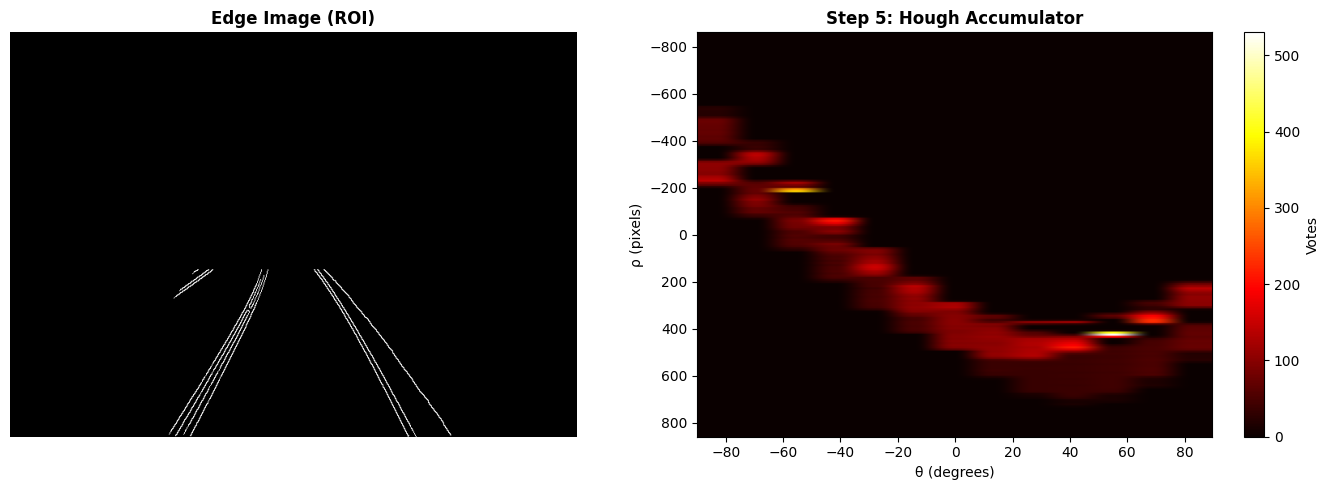

In [291]:
# Hough Accumulator Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].imshow(roi_image, cmap='gray')
axes[0].set_title("Edge Image (ROI)", fontsize=12, fontweight='bold')
axes[0].axis('off')

# Hough Accumulator
im = axes[1].imshow(accumulator, cmap='hot', aspect='auto', 
                    extent=[np.degrees(thetas[0]), np.degrees(thetas[-1]), rhos[-1], rhos[0]])
axes[1].set_title("Step 5: Hough Accumulator", fontsize=12, fontweight='bold')
axes[1].set_xlabel("θ (degrees)")
axes[1].set_ylabel("ρ (pixels)")
plt.colorbar(im, ax=axes[1], label='Votes')

plt.tight_layout()
plt.show()

---

## Step 6: Line Filtering and Adjustment

### Purpose
- Eliminate duplicate or too-close lines
- Select the two most relevant lines (left and right)
- Refine line positions

### Method
1. **Scoring**: Evaluate the quality of each line (number of edge pixels it covers)
2. **Duplicate removal**: Eliminate lines that are too similar
3. **Local optimization**: Fine-tune angle and position

In [292]:
def score_line(rho: float, theta: float, edges: np.ndarray) -> float:
    """Calculates the score of a line (number of edge pixels covered)."""
    mask = np.zeros(edges.shape, dtype=edges.dtype)
    
    normal = polar2cartesian(rho, theta)
    direction = np.array([normal[1], -normal[0]])
    
    p1 = np.round(normal + 1000 * direction).astype(int)
    p2 = np.round(normal - 1000 * direction).astype(int)
    
    cv2.line(mask, tuple(p1), tuple(p2), 255, 12)
    
    return cv2.countNonZero(cv2.bitwise_and(mask, edges))

def filter_lines(edges: np.ndarray, lines: np.ndarray, min_separation: int = 210) -> np.ndarray:
    """
    Filters lines to keep the two best (left and right).
    """
    if lines is None or len(lines) == 0:
        return np.empty((0, 2))
    
    # Score all lines
    scored = []
    for rho, theta in lines:
        score = score_line(rho, theta, edges)
        scored.append([rho, theta, score])
    scored = np.array(scored)
    
    # Keep strong lines
    max_score = scored[:, 2].max()
    if max_score == 0:
        return np.empty((0, 2))
    strong = scored[scored[:, 2] > 0.3 * max_score]
    strong = strong[strong[:, 2].argsort()[::-1]]
    
    # Remove duplicates
    filtered = []
    for rho, theta, score in strong:
        keep = True
        for r2, t2, _ in filtered:
            if abs(rho - r2) < 230 and abs(theta - t2) < np.deg2rad(5):
                keep = False
                break
        if keep:
            filtered.append([rho, theta, score])
        if len(filtered) >= 10:
            break
    
    if len(filtered) < 2:
        return np.array(filtered)[:, :2] if filtered else np.empty((0, 2))
    
    filtered = np.array(filtered)
    
    # Find the most separated pair
    max_dist = 0
    best_pair = None
    for i in range(len(filtered)):
        for j in range(i + 1, len(filtered)):
            dist = abs(filtered[i][0] - filtered[j][0])
            if dist > max_dist:
                max_dist = dist
                best_pair = (filtered[i], filtered[j])
    
    if max_dist < min_separation or best_pair is None:
        return filtered[:1, :2]
    
    return np.array([best_pair[0][:2], best_pair[1][:2]])

# Apply filtering
filtered_lines = filter_lines(roi_image, lines)
print(f"Lines after filtering: {len(filtered_lines)}")
for i, (rho, theta) in enumerate(filtered_lines):
    print(f"   Line {i+1}: \u03c1={rho:.1f}, \u03b8={np.degrees(theta):.1f}\u00b0")

Lines after filtering: 2
   Line 1: ρ=-185.2, θ=-60.1°
   Line 2: ρ=480.8, θ=44.6°


In [293]:
def optimize_lines(lines: np.ndarray, edges: np.ndarray) -> np.ndarray:
    """
    Optimizes lines through local search.
    """
    if len(lines) == 0:
        return lines
    
    optimized = []
    angle_range = np.deg2rad(15)
    angle_step = np.deg2rad(0.5)
    rho_range = 50
    rho_step = 5
    
    for rho, theta in lines:
        best_rho = rho
        best_theta = theta
        best_score = score_line(rho, theta, edges)
        
        # Search in neighborhood
        for test_rho in np.arange(rho - rho_range, rho + rho_range + 1, rho_step):
            for test_theta in np.arange(theta - angle_range, theta + angle_range, angle_step):
                score = score_line(test_rho, test_theta, edges)
                if score > best_score:
                    best_score = score
                    best_rho = test_rho
                    best_theta = test_theta
        
        optimized.append([best_rho, best_theta])
    
    return np.array(optimized)

# Optimization
optimized_lines = optimize_lines(filtered_lines, roi_image)
print("Lines optimized!")
for i, (rho, theta) in enumerate(optimized_lines):
    print(f"   Line {i+1}: \u03c1={rho:.1f}, \u03b8={np.degrees(theta):.1f}\u00b0")

Lines optimized!
   Line 1: ρ=-195.2, θ=-61.1°
   Line 2: ρ=430.8, θ=58.6°


---

## Step 7: Drawing Lines on Original Image

### Purpose
Overlay detected lines on the original image to visualize the result.

### Method
1. Convert polar coordinates to cartesian points
2. Draw lines on a masked image
3. Merge with original image

In [294]:
def draw_lines(img: np.ndarray, lines: np.ndarray, mask: np.ndarray, 
               color: list, thickness: int) -> np.ndarray:
    """
    Draws detected lines on the image.
    
    Parameters:
        img: Original image
        lines: Lines in polar coordinates
        mask: ROI mask
        color: Line color [B, G, R]
        thickness: Line thickness
    
    Returns:
        Image with drawn lines
    """
    empty_image = np.zeros(img.shape[:2])
    new_img = img.copy()

    for rho, theta in lines:
        normal = polar2cartesian(rho, theta)
        direction = np.array([normal[1], -normal[0]])
        
        p1 = np.round(normal + 1000 * direction).astype(int)
        p2 = np.round(normal - 1000 * direction).astype(int)
        
        empty_image = cv2.line(img=empty_image, pt1=p1, pt2=p2, 
                               color=255, thickness=thickness)

    # Apply mask
    mask_lines = empty_image > 0
    final_mask = (mask * mask_lines).astype(bool)
    new_img[final_mask] = np.array(color)

    return new_img

# Draw lines
LINE_COLOR = [0, 255, 0]  # Green (BGR)
LINE_THICKNESS = 7

result_image = draw_lines(original_image, optimized_lines, roi_mask, LINE_COLOR, LINE_THICKNESS)

---

## 4. Final Result

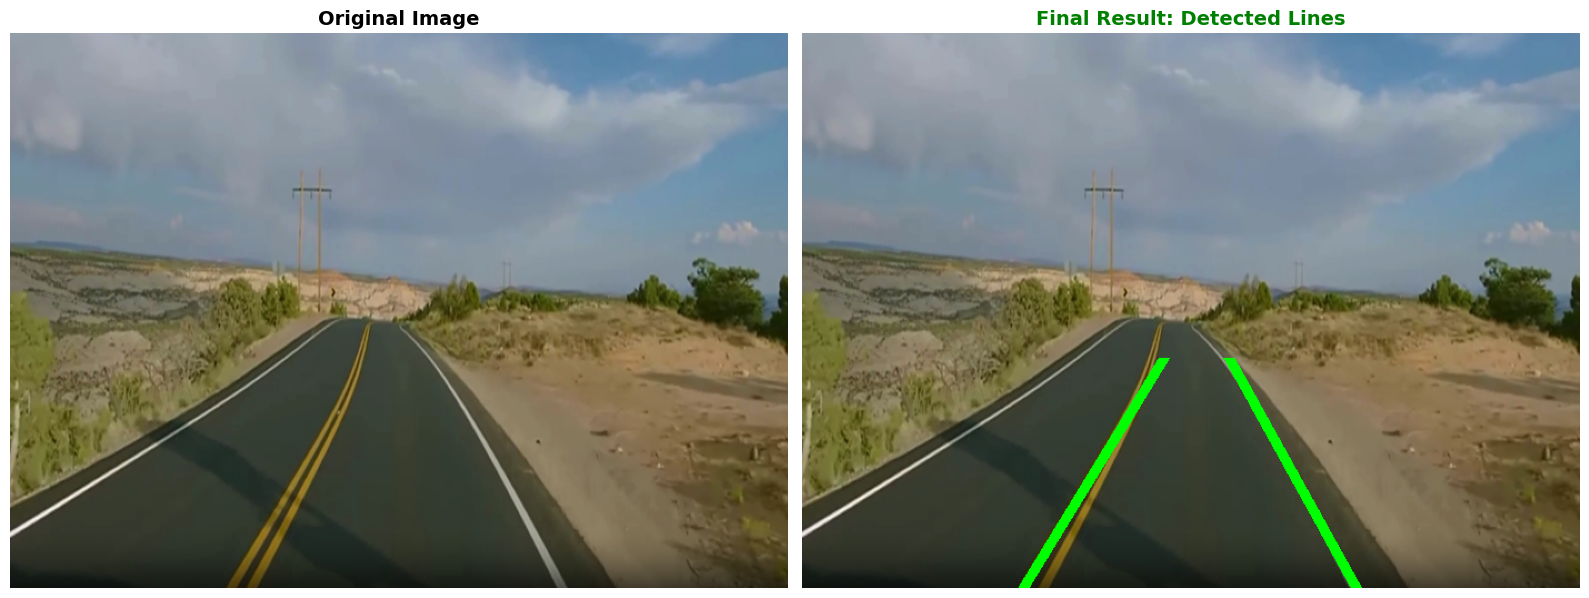

Lane line detection completed successfully!


In [295]:
# Display final result
result_rgb = cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].imshow(image_rgb)
axes[0].set_title("Original Image", fontsize=14, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(result_rgb)
axes[1].set_title("Final Result: Detected Lines", fontsize=14, fontweight='bold', color='green')
axes[1].axis('off')

plt.tight_layout()
plt.show()

print("Lane line detection completed successfully!")

---

## 5. Conclusion

### Achievements
- **From scratch** implementation of a lane line detection system
- Mastery of fundamental computer vision concepts:
  - Grayscale conversion
  - Gaussian blur and convolution
  - Edge detection (Canny algorithm)
  - Hough Transform
  - Line filtering and optimization

### Key Learnings
- Understanding of gradient operators (Sobel)
- Mastery of thresholding and hysteresis techniques
- Practical application of the Hough Transform

### Future Improvements
- Integration of **Deep Learning** techniques for greater robustness
- Handling of **curves** (probabilistic Hough transform)
- Adaptation to **variable weather conditions**
- Optimization for **real-time processing**

---
